In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv("C:/Users/LENOVO/Desktop/dataset/FraudDetection/fraudTrain.csv")

# **Data Perprocessing**

In [4]:
print(df.isnull().sum())

ID             0
Time           0
Card Number    0
merchant       0
category       0
Amount         1
firstName      1
lastName       1
trans_num      1
is_fraud       1
dtype: int64


handling missing values

In [5]:
df.dropna(how='any',inplace=True)
df.duplicated()
print(df.isnull().sum())

ID             0
Time           0
Card Number    0
merchant       0
category       0
Amount         0
firstName      0
lastName       0
trans_num      0
is_fraud       0
dtype: int64


converting all categorical data

In [6]:
print(df.dtypes)

ID               int64
Time            object
Card Number    float64
merchant        object
category        object
Amount         float64
firstName       object
lastName        object
trans_num       object
is_fraud       float64
dtype: object


In [7]:
def Feature_Encoder(X,cols):
    for c in cols:
        lbl = LabelEncoder()
        lbl.fit(list(X[c].values))
        X[c] = lbl.transform(list(X[c].values))
    return X

In [8]:
cols=('merchant','category','firstName','lastName','trans_num')
data = Feature_Encoder(df,cols)
print(df.dtypes)

ID               int64
Time            object
Card Number    float64
merchant         int32
category         int32
Amount         float64
firstName        int32
lastName         int32
trans_num        int32
is_fraud       float64
dtype: object


**detect the outliers**

In [10]:
# def detect_outliers_z_score(df):
#     threshold = 3
#     mean = df['Amount'].mean()
#     std_dev = df['Amount'].std()
#     df['Z_Score'] = (df['Amount'] - mean) / std_dev
#     df['Outlier'] = abs(df['Z_Score']) > threshold
#     return df

In [11]:
# df = detect_outliers_z_score(df)
# print(df)

In [12]:
# print(df['Outlier'].value_counts())

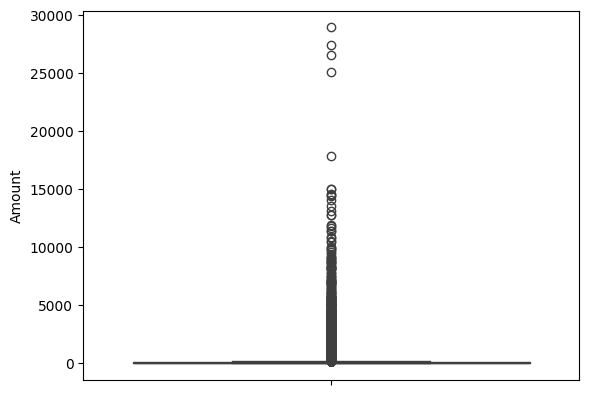

In [9]:
sns.boxplot(df['Amount'])
plt.show()

handling amout outliers

In [10]:
print(data['Amount'].max())
print(data['Amount'].min())

28948.9
1.0


In [15]:
# q1 = np.percentile(df['Amount'], 25)
# q3 = np.percentile(df['Amount'], 75)

# iqr = q3 - q1

# lower_bound = q1 - 1.5 * iqr
# upper_bound = q3 + 1.5 * iqr

In [16]:
# # Imputing the Outliers
# def impute_outliers(df):
#     df.loc[df['Outlier'], 'Amount'] = df.loc[df['Outlier'], 'Amount'].apply(
#         lambda x: q3 if x > q3 else (q1 if x < q1 else x)
#     )
#     return df

In [17]:
# df = impute_outliers(df)
# print("\nDataFrame after Imputing Outliers:")
# print(df[['Amount', 'Outlier']])

we try to imputing outliers but we see that the amount corelation relation vaule was decreased, so we had used the original data of the column

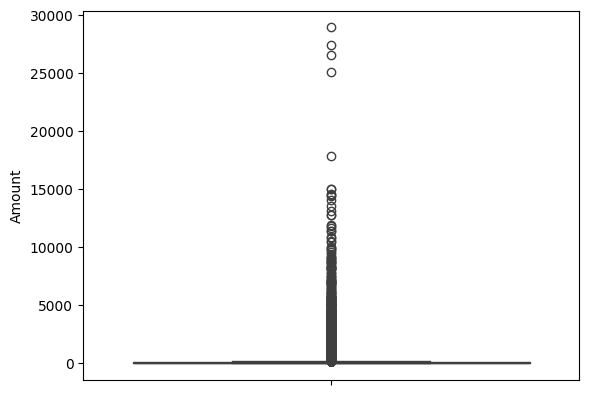

In [11]:
sns.boxplot(df['Amount'])
plt.show()

In [12]:
print(data['Amount'].max())
print(data['Amount'].min())

28948.9
1.0


In [13]:
mean_amount = data['Amount'].mean()
print(mean_amount)

data['diff_amount'] = abs(data['Amount'] - mean_amount)
print(data['diff_amount']) #difference between current amount and the mean of amount

70.25615704174125
0           65.286157
1           36.973843
2          149.853843
3           25.256157
4           28.296157
              ...    
1002098     27.313843
1002099     67.386157
1002100     61.166157
1002101     60.256157
1002102     63.596157
Name: diff_amount, Length: 1002103, dtype: float64


In [14]:
data.head()

,ID,Time,Card Number,merchant,category,Amount,firstName,lastName,trans_num,is_fraud,diff_amount
0,0,1/1/2019 0:00,2.700000e+15,514,8,4.97,160,18,43723,0.0,65.286157
1,1,1/1/2019 0:00,6.300000e+11,241,4,107.23,305,156,123180,0.0,36.973843
2,2,1/1/2019 0:00,3.890000e+13,390,0,220.11,113,379,632681,0.0,149.853843
3,3,1/1/2019 0:01,3.530000e+15,360,2,45.00,161,460,420764,0.0,25.256157
4,4,1/1/2019 0:03,3.760000e+14,297,9,41.96,331,148,642198,0.0,28.296157


Feature Engineering

In [15]:
seconds_per_minute = 60
seconds_per_hour = 60 * seconds_per_minute
seconds_per_day = 24 * seconds_per_hour
seconds_per_month = 30 * seconds_per_day
seconds_per_year = 365 * seconds_per_day

In [16]:
data = data.iloc[:,:]
data['Time'] = pd.to_datetime(df['Time'])
data['Min'] = data['Time'].dt.minute * seconds_per_minute
data['Hour'] = data['Time'].dt.hour  *seconds_per_hour
data['Day'] = data['Time'].dt.day * seconds_per_day
data['Month'] = data['Time'].dt.month * seconds_per_month
data['Year'] = data['Time'].dt.year * seconds_per_year
data['total_seconds'] = (data['Min'] + data['Hour'] + data['Day'] + data['Month'] + data['Year'])

In [17]:
data['difference_seconds'] = data['total_seconds'].diff().fillna(0) # to make the first time record the base of time
total_seconds_mean = data['total_seconds'].mean()
data['difference_seconds_mean'] = data['total_seconds'] - total_seconds_mean
data['diff_abs'] = abs(data['difference_seconds_mean'])
data = data.drop(columns=['total_seconds'])

In [18]:
data.head()

,ID,Time,Card Number,merchant,category,Amount,firstName,lastName,trans_num,is_fraud,diff_amount,Min,Hour,Day,Month,Year,difference_seconds,difference_seconds_mean,diff_abs
0,0,2019-01-01 00:00:00,2.700000e+15,514,8,4.97,160,18,43723,0.0,65.286157,0,0,86400,2592000,-753325440,0.0,-1.851931e+07,1.851931e+07
1,1,2019-01-01 00:00:00,6.300000e+11,241,4,107.23,305,156,123180,0.0,36.973843,0,0,86400,2592000,-753325440,0.0,-1.851931e+07,1.851931e+07
2,2,2019-01-01 00:00:00,3.890000e+13,390,0,220.11,113,379,632681,0.0,149.853843,0,0,86400,2592000,-753325440,0.0,-1.851931e+07,1.851931e+07
3,3,2019-01-01 00:01:00,3.530000e+15,360,2,45.00,161,460,420764,0.0,25.256157,60,0,86400,2592000,-753325440,60.0,-1.851925e+07,1.851925e+07
4,4,2019-01-01 00:03:00,3.760000e+14,297,9,41.96,331,148,642198,0.0,28.296157,180,0,86400,2592000,-753325440,120.0,-1.851913e+07,1.851913e+07


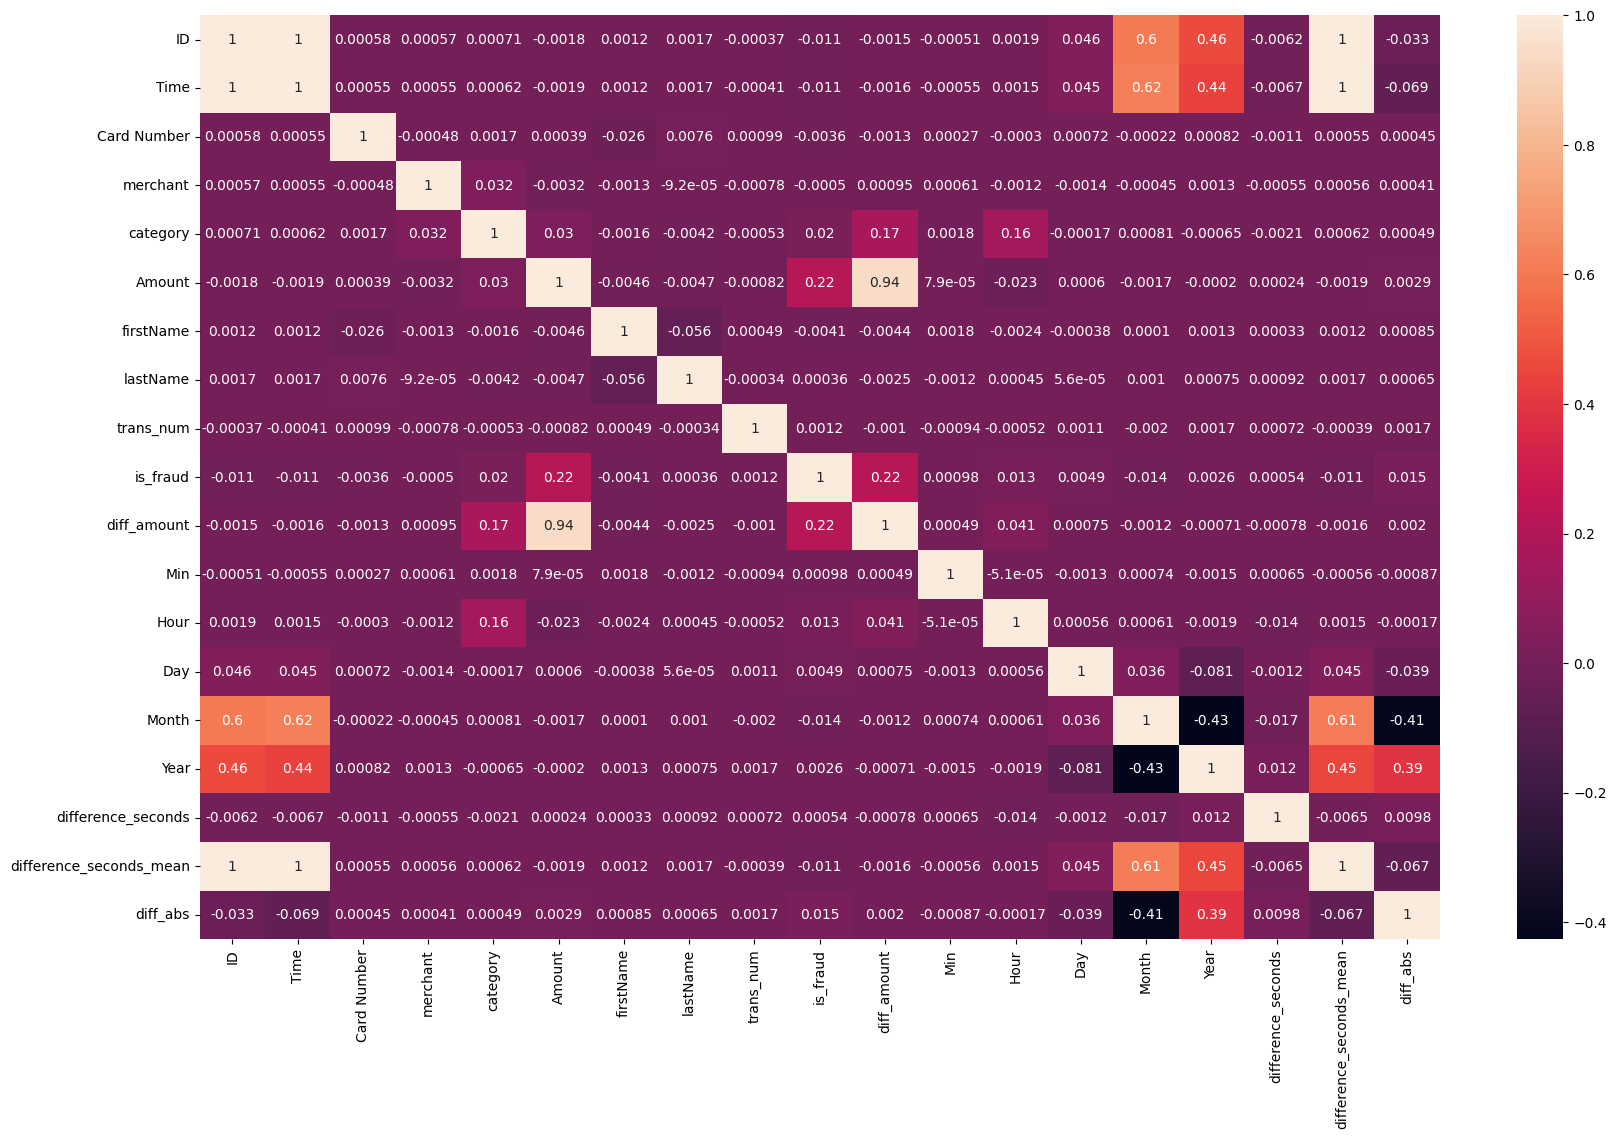

In [27]:
corr = data.corr()
#Top 50% Correlation training features with the Value
top_feature = corr.index[abs(corr['is_fraud']>0.5)]
#Correlation plot
plt.subplots(figsize=(20, 12))
top_corr = data.corr()
sns.heatmap(top_corr, annot=True)
plt.show()

here we see that the most columns that has impact on the target column (is_fraud) is:
category, Amount, hour, diff_abs



In [19]:
data = data.drop(columns = ['ID','Time','merchant','Card Number', 'firstName','lastName','trans_num','Min','Day','Month','Year','difference_seconds','difference_seconds_mean'])

diff amount has the same impact in "is_fraud" column so we can drop it

In [20]:
data = data.drop(columns = ['diff_amount'])

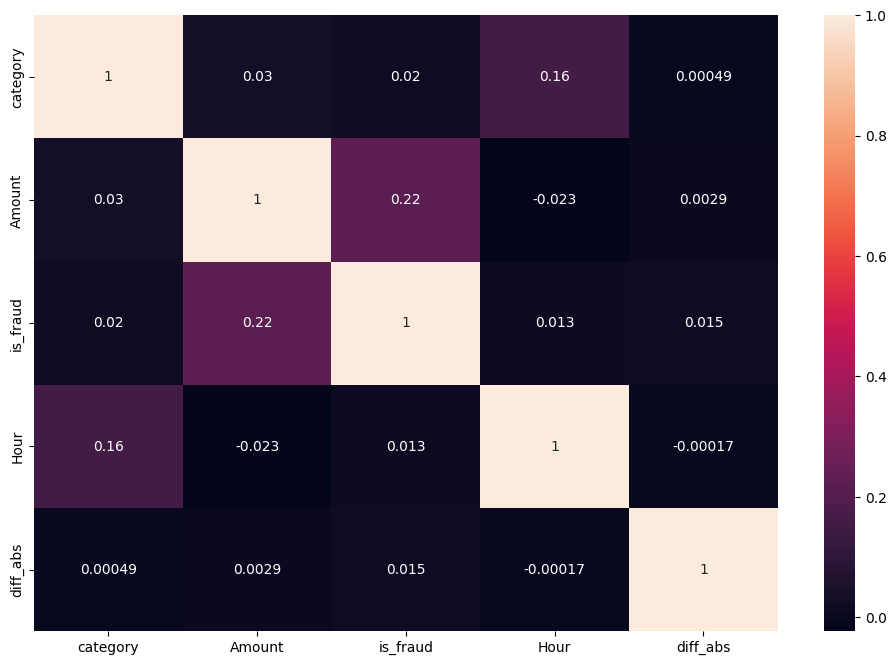

In [30]:
corr = data.corr()
#Top 50% Correlation training features with the Value
top_feature = corr.index[abs(corr['is_fraud']>0.5)]
#Correlation plot
plt.subplots(figsize=(12, 8))
top_corr = data.corr()
sns.heatmap(top_corr, annot=True)
plt.show()

In [21]:
data.head()

,category,Amount,is_fraud,Hour,diff_abs
0,8,4.97,0.0,0,1.851931e+07
1,4,107.23,0.0,0,1.851931e+07
2,0,220.11,0.0,0,1.851931e+07
3,2,45.00,0.0,0,1.851925e+07
4,9,41.96,0.0,0,1.851913e+07


In [22]:
x_init_train = data.drop(columns=['is_fraud'])
y_init_train = data['is_fraud']


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18052\2239573080.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y = count.values, palette ='viridis')


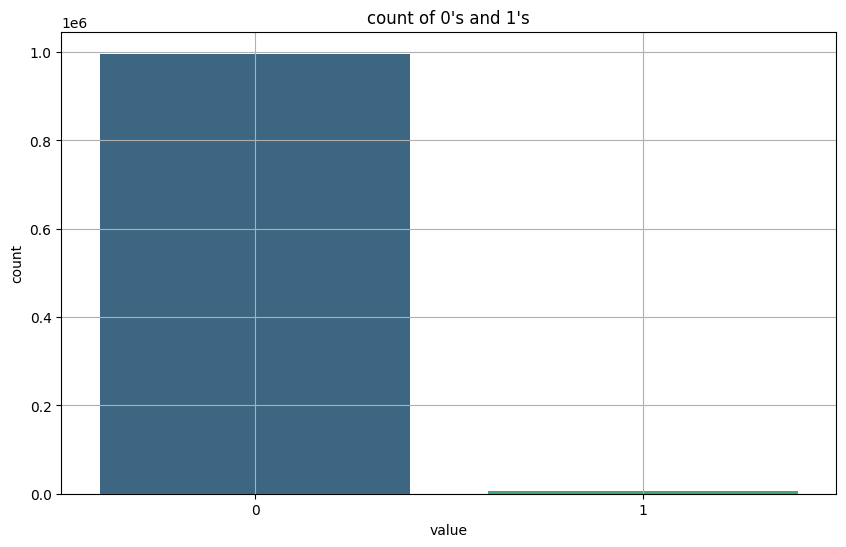

In [23]:
count = y_init_train.value_counts().sort_index()

plt.figure(figsize=(10,6))

sns.barplot(x=count.index, y = count.values, palette ='viridis')
plt.title('count of 0\'s and 1\'s')
plt.xlabel('value')
plt.ylabel('count')
plt.xticks([0,1], ['0', '1'])
plt.grid(True)

plt.show()

In [24]:
smote = SMOTE(sampling_strategy=0.5) # type: ignore
X_resampled, y_resampled = smote.fit_resample(x_init_train, y_init_train)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18052\3364640487.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y = count.values, palette ='viridis')


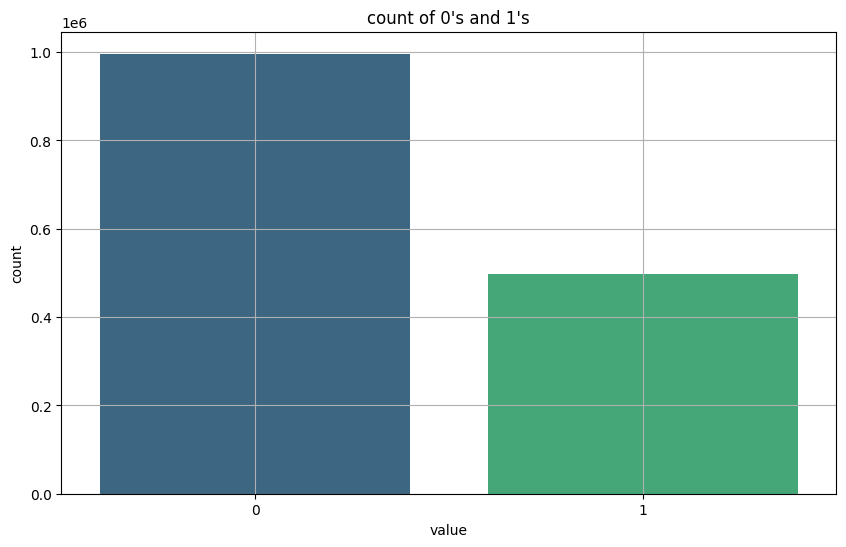

In [25]:
count = y_resampled.value_counts().sort_index()

plt.figure(figsize=(10,6))

sns.barplot(x=count.index, y = count.values, palette ='viridis')
plt.title('count of 0\'s and 1\'s')
plt.xlabel('value')
plt.ylabel('count')
plt.xticks([0,1], ['0', '1'])
plt.grid(True)

plt.show()

In [34]:
print(len(y_resampled))

1494585


here we try to give the features a standard scaler and model got low accuracy 

# **train and evaluate models**

In [35]:
# scaler = StandardScaler()
# scaler.fit(X_resampled)
# X_resampled = scaler.transform(X_resampled)


In [36]:
# scaler.fit(x_init_train)
# x_init_train = scaler.transform(x_init_train)


In [37]:
X_train_noUpsample, X_test_noUpsample, y_train_noUpsample, y_test_noUpsample = train_test_split(x_init_train, y_init_train, test_size=0.2, random_state=42)

# **XGBOOST model**

In [38]:
xg_Class_noUpsample = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

In [39]:
cv_scores_noUpSampled = cross_val_score(xg_Class_noUpsample, X_train_noUpsample, y_train_noUpsample, cv=5)

In [40]:
xg_Class_noUpsample.fit(X_train_noUpsample, y_train_noUpsample)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [41]:
y_pred_noUpsample = xg_Class_noUpsample.predict(X_test_noUpsample)

In [42]:
accuracy = accuracy_score(y_test_noUpsample, y_pred_noUpsample)
precision = precision_score(y_test_noUpsample, y_pred_noUpsample)
recall = recall_score(y_test_noUpsample, y_pred_noUpsample)
f1 = f1_score(y_test_noUpsample, y_pred_noUpsample)


print(f"Accuracy on test set: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy on test set: 0.9978994217172851
Precision: 0.88
Recall: 0.71
F1-Score: 0.79


In [43]:
cm_test_noUpsample = confusion_matrix(y_test_noUpsample, y_pred_noUpsample)
print(cm_test_noUpsample)

[[199231    103]
 [   318    769]]


xgb model with upsampled data

In [44]:
xg_Class = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42) #upsample

In [46]:
cv_scores = cross_val_score(xg_Class, X_train, y_train, cv=5)

In [47]:
xg_Class.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [48]:
y_pred = xg_Class.predict(X_test)

In [49]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy of dataset: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy of dataset: 0.9759832997119602
Precision: 0.98
Recall: 0.95
F1-Score: 0.96


In [50]:
cm_test = confusion_matrix(y_test, y_pred)
print(cm_test)

[[196566   2409]
 [  4770  95172]]


# **Random forest model**

In [51]:
rf_class_noUpSampled = RandomForestClassifier(random_state=42)

grid search -- too much time to run (more than 4 hours)

In [52]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [4, 6, 8, None],
#     'criterion': ['gini', 'entropy']
# }

In [53]:
# grid_search = GridSearchCV(estimator=rf_class_noUpSampled, param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=2)

# grid_search.fit(X_train_noUpsample, y_train_noUpsample)

In [54]:
cv_scores = cross_val_score(rf_class_noUpSampled, X_train_noUpsample, y_train_noUpsample,cv=5)

In [55]:
rf_class_noUpSampled.fit(X_train_noUpsample, y_train_noUpsample)

RandomForestClassifier(random_state=42)

In [56]:
y_pred_noUpsample = rf_class_noUpSampled.predict(X_test_noUpsample)

In [57]:
accuracy = accuracy_score(y_test_noUpsample, y_pred_noUpsample)
precision = precision_score(y_test_noUpsample, y_pred_noUpsample)
recall = recall_score(y_test_noUpsample, y_pred_noUpsample)
f1 = f1_score(y_test_noUpsample, y_pred_noUpsample)


print(f"Accuracy on test set: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy on test set: 0.9978595057404164
Precision: 0.87
Recall: 0.72
F1-Score: 0.78


In [58]:
cm_test = confusion_matrix(y_test_noUpsample, y_pred_noUpsample)
print(cm_test)

[[199214    120]
 [   309    778]]


rf model using up sampled data

In [59]:
rf_class = RandomForestClassifier(random_state=42)

In [60]:
cv_scores = cross_val_score(rf_class, X_train, y_train,cv=5)

In [61]:
rf_class.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [62]:
y_pred = rf_class.predict(X_test)

In [63]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy of dataset: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy of dataset: 0.9855779363502243
Precision: 0.98
Recall: 0.98
F1-Score: 0.98


In [64]:
cm_test = confusion_matrix(y_test, y_pred)
print(cm_test)

[[196908   2067]
 [  2244  97698]]


# **Logistic regression model**

In [65]:
lr_model_noUpsample = LogisticRegression(max_iter=1000, random_state=42)

In [66]:
cv_scores = cross_val_score(lr_model_noUpsample, X_train_noUpsample, y_train_noUpsample, cv=5)

In [67]:
lr_model_noUpsample.fit(X_train_noUpsample, y_train_noUpsample)

LogisticRegression(max_iter=1000, random_state=42)

In [68]:
y_pred = lr_model_noUpsample.predict(X_test_noUpsample)

In [69]:
accuracy = accuracy_score(y_test_noUpsample, y_pred_noUpsample)
precision = precision_score(y_test_noUpsample, y_pred_noUpsample)
recall = recall_score(y_test_noUpsample, y_pred_noUpsample)
f1 = f1_score(y_test_noUpsample, y_pred_noUpsample)


print(f"Accuracy on test set: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy on test set: 0.9978595057404164
Precision: 0.87
Recall: 0.72
F1-Score: 0.78


lr model using up sampled data

In [70]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)

In [71]:
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5)

In [72]:
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [73]:
y_pred = lr_model.predict(X_test)

In [74]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy of dataset: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy of dataset: 0.8982694192702322
Precision: 0.90
Recall: 0.78
F1-Score: 0.84


In [75]:
cm_test = confusion_matrix(y_test, y_pred)
print(cm_test)

[[190383   8592]
 [ 21817  78125]]


# **dession tree model** 

In [76]:
dt_model_noUpsample = DecisionTreeClassifier(max_depth=None, random_state=42)

In [77]:
cv_scores = cross_val_score(dt_model_noUpsample, X_train_noUpsample, y_train_noUpsample, cv=5)

In [78]:
dt_model_noUpsample.fit(X_train_noUpsample, y_train_noUpsample)

DecisionTreeClassifier(random_state=42)

In [79]:
y_pred = dt_model_noUpsample.predict(X_test_noUpsample)

In [80]:
accuracy = accuracy_score(y_test_noUpsample, y_pred_noUpsample)
precision = precision_score(y_test_noUpsample, y_pred_noUpsample)
recall = recall_score(y_test_noUpsample, y_pred_noUpsample)
f1 = f1_score(y_test_noUpsample, y_pred_noUpsample)


print(f"Accuracy on test set: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy on test set: 0.9978595057404164
Precision: 0.87
Recall: 0.72
F1-Score: 0.78


In [81]:
cm_test = confusion_matrix(y_test_noUpsample, y_pred_noUpsample)
print(cm_test)

[[199214    120]
 [   309    778]]


dt model using up sampled data 

In [82]:
dt_model = DecisionTreeClassifier(max_depth=None, random_state=42)

In [83]:
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5)

In [84]:
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [85]:
y_pred = dt_model.predict(X_test)

In [86]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy of dataset: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy of dataset: 0.9841159920646868
Precision: 0.97
Recall: 0.98
F1-Score: 0.98


In [87]:
cm_test = confusion_matrix(y_test, y_pred)
print(cm_test)

[[196334   2641]
 [  2107  97835]]


# **K-nearest neighbor**

In [88]:
knn_model_noUpsample = KNeighborsClassifier(n_neighbors=5)

In [89]:
cv_scores_noUpsample = cross_val_score(knn_model_noUpsample, X_train_noUpsample, y_train_noUpsample, cv=5)

In [90]:
knn_model_noUpsample.fit(X_train_noUpsample, y_train_noUpsample)

KNeighborsClassifier()

In [91]:
y_pred_noUpsample = knn_model_noUpsample.predict(X_test_noUpsample)

In [92]:
accuracy = accuracy_score(y_test_noUpsample, y_pred_noUpsample)
precision = precision_score(y_test_noUpsample, y_pred_noUpsample)
recall = recall_score(y_test_noUpsample, y_pred_noUpsample)
f1 = f1_score(y_test_noUpsample, y_pred_noUpsample)


print(f"Accuracy on test set: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy on test set: 0.9947710070302014
Precision: 0.79
Recall: 0.05
F1-Score: 0.09


In [93]:
cm_test = confusion_matrix(y_test_noUpsample, y_pred_noUpsample)
print(cm_test)

[[199320     14]
 [  1034     53]]


knn using upsampled data

In [94]:
knn_model = KNeighborsClassifier(n_neighbors=5)

In [95]:
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5)

In [96]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [97]:
y_pred = knn_model.predict(X_test)

In [98]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy of dataset: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy of dataset: 0.9728754135763439
Precision: 0.97
Recall: 0.95
F1-Score: 0.96


In [99]:
cm_test = confusion_matrix(y_test, y_pred)
print(cm_test)

[[195638   3337]
 [  4771  95171]]


# **Support vector machine model**

too much time to run

In [100]:
# svm_model_noUpsample = SVC(kernel='linear', C=1.0, random_state=42)

In [101]:
# cv_scores = cross_val_score(svm_model_noUpsample, X_train_noUpsample, y_train_noUpsample, cv=5)

In [102]:
# svm_model_noUpsample.fit(X_train_noUpsample, y_train_noUpsample)

In [103]:
# y_pred_noUpsample = svm_model_noUpsample.predict(X_test_noUpsample)

In [104]:
# accuracy = accuracy_score(y_test_noUpsample, y_pred_noUpsample)
# precision = precision_score(y_test_noUpsample, y_pred_noUpsample)
# recall = recall_score(y_test_noUpsample, y_pred_noUpsample)
# f1 = f1_score(y_test_noUpsample, y_pred_noUpsample)


# print(f"Accuracy on test set: {accuracy}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1-Score: {f1:.2f}")

In [105]:
# cm_test = confusion_matrix(y_test_noUpsample, y_pred_noUpsample)
# print(cm_test)

svm using upsampled data

In [106]:
# svm_model = SVC(kernel='linear', C=1.0, random_state=42)

In [107]:
# cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)

In [108]:
# svm_model.fit(X_train, y_train)

In [109]:
# y_pred = svm_model.predict(X_test)

In [110]:
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print(f"Accuracy of dataset: {accuracy}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1-Score: {f1:.2f}")


In [111]:
# cm_test = confusion_matrix(y_test, y_pred)
# print(cm_test)

# **now we can use the test data file**

In [113]:
test = pd.read_excel("C:/Users/LENOVO/Desktop/dataset/FraudDetection/fraudTest.xlsx")

# **Data Perprocessing**  for test data

In [114]:
print(test.isnull().sum())

ID             0
Time           0
Card Number    0
merchant       0
category       0
Amount         0
firstName      0
lastName       0
trans_num      0
is_fraud       0
dtype: int64


In [115]:
print(test.dtypes)

ID                      int64
Time           datetime64[ns]
Card Number             int64
merchant               object
category               object
Amount                float64
firstName              object
lastName               object
trans_num              object
is_fraud                int64
dtype: object


Feature encoder

In [116]:
test = Feature_Encoder(test,cols)
print(test.dtypes)

ID                      int64
Time           datetime64[ns]
Card Number             int64
merchant                int32
category                int32
Amount                float64
firstName               int32
lastName                int32
trans_num               int32
is_fraud                int64
dtype: object


# **feature engineering**


In [117]:
# mean_amount = test['Amount'].mean()
# print(mean_amount)

# test['diff_amount'] = abs(test['Amount'] - mean_amount)
# print(test['diff_amount'])

In [118]:
test.head()

,ID,Time,Card Number,merchant,category,Amount,firstName,lastName,trans_num,is_fraud
0,0,2020-06-21 12:14:25,2291163933867240,319,10,2.86,151,115,98699,0
1,1,2020-06-21 12:14:33,3573030041201290,591,10,29.84,163,457,108785,0
2,2,2020-06-21 12:14:53,3598215285024750,611,5,41.28,24,249,433979,0
3,3,2020-06-21 12:15:15,3591919803438420,222,9,60.05,42,457,71993,0
4,4,2020-06-21 12:15:17,3526826139003040,292,13,3.19,247,261,190585,0


In [119]:
test_data = test.iloc[:,:]
test_data['Time'] = pd.to_datetime(test['Time'])
test_data['Min'] = test_data['Time'].dt.minute * seconds_per_minute
test_data['Hour'] = test_data['Time'].dt.hour  *seconds_per_hour
test_data['Day'] = test_data['Time'].dt.day * seconds_per_day
test_data['Month'] = test_data['Time'].dt.month * seconds_per_month
test_data['Year'] = test_data['Time'].dt.year * seconds_per_year
test_data['total_seconds'] = (test_data['Min'] + test_data['Hour'] + test_data['Day'] + test_data['Month'] + test_data['Year'])

In [120]:
test_data['difference_seconds'] = test_data['total_seconds'].diff().fillna(0) # to make the first time record the base of time

total_seconds_mean = test_data['total_seconds'].mean()
test_data['difference_seconds_mean'] = test_data['total_seconds'] - total_seconds_mean

test_data['diff_abs'] = abs(test_data['difference_seconds_mean'])
test_data = test_data.drop(columns=['Time','Min','Day','Month','Year','total_seconds','difference_seconds_mean','difference_seconds'])

In [121]:
print(total_seconds_mean)

-695672951.2278328


In [122]:
test_data.head()

,ID,Card Number,merchant,category,Amount,firstName,lastName,trans_num,is_fraud,Hour,diff_abs
0,0,2291163933867240,319,10,2.86,151,115,98699,0,43200,8.706049e+06
1,1,3573030041201290,591,10,29.84,163,457,108785,0,43200,8.706049e+06
2,2,3598215285024750,611,5,41.28,24,249,433979,0,43200,8.706049e+06
3,3,3591919803438420,222,9,60.05,42,457,71993,0,43200,8.705989e+06
4,4,3526826139003040,292,13,3.19,247,261,190585,0,43200,8.705989e+06


In [123]:
test_data = test_data.drop(columns=['ID','Card Number','merchant','firstName','lastName','trans_num'])

In [125]:
test_data.head()

,category,Amount,is_fraud,Hour,diff_abs
0,10,2.86,0,43200,8.706049e+06
1,10,29.84,0,43200,8.706049e+06
2,5,41.28,0,43200,8.706049e+06
3,9,60.05,0,43200,8.705989e+06
4,13,3.19,0,43200,8.705989e+06


In [127]:
data.head()

,category,Amount,is_fraud,Hour,diff_abs
0,8,4.97,0.0,0,1.851931e+07
1,4,107.23,0.0,0,1.851931e+07
2,0,220.11,0.0,0,1.851931e+07
3,2,45.00,0.0,0,1.851925e+07
4,9,41.96,0.0,0,1.851913e+07


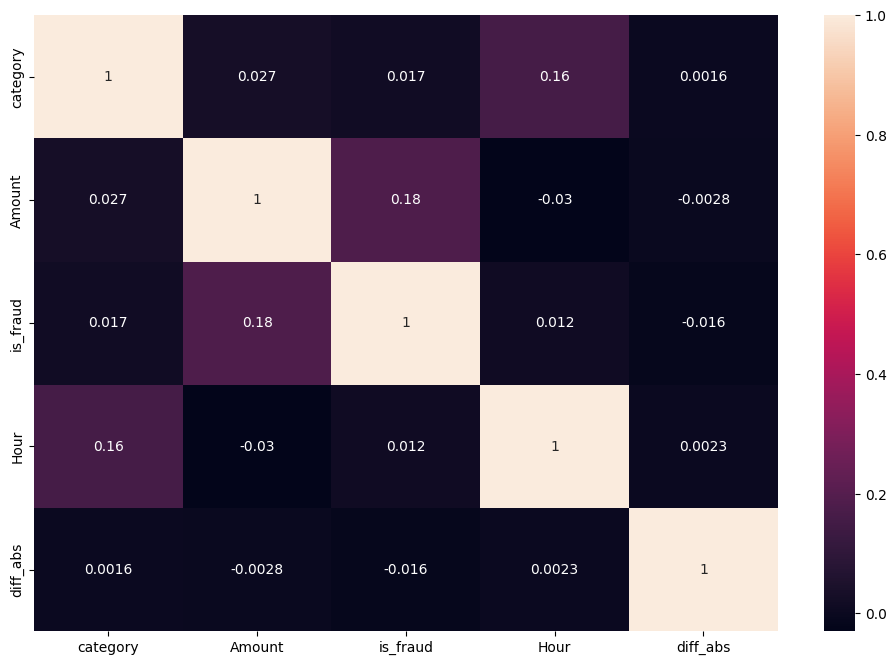

In [128]:
corr = test_data.corr()
#Top 50% Correlation training features with the Value
top_feature = corr.index[abs(corr['is_fraud']>0.5)]
#Correlation plot
plt.subplots(figsize=(12, 8))
top_corr = test_data.corr()
sns.heatmap(top_corr, annot=True)
plt.show()

In [129]:
x_init_test = test_data.drop(columns=['is_fraud'])
y_init_test = test_data['is_fraud']

# **XGBOOST**

In [130]:
y_pred_test_noUpsample = xg_Class_noUpsample.predict(x_init_test)

In [131]:
accuracy = accuracy_score(y_init_test, y_pred_test_noUpsample)
precision = precision_score(y_init_test, y_pred_test_noUpsample)
recall = recall_score(y_init_test, y_pred_test_noUpsample)
f1 = f1_score(y_init_test, y_pred_test_noUpsample)

print(f"Accuracy of dataset : {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy of dataset : 0.9978946194029716
Precision: 0.78
Recall: 0.63
F1-Score: 0.70


In [132]:
cm_test = confusion_matrix(y_init_test, y_pred_test_noUpsample)
print(cm_test)

[[553190    384]
 [   786   1359]]


testing on upsampled data trained model

In [133]:
y_pred_test = xg_Class.predict(x_init_test)

In [134]:
accuracy = accuracy_score(y_init_test, y_pred_test)
precision = precision_score(y_init_test, y_pred_test)
recall = recall_score(y_init_test, y_pred_test)
f1 = f1_score(y_init_test, y_pred_test)

print(f"Accuracy dataset: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy dataset: 0.9890358256600909
Precision: 0.23
Recall: 0.81
F1-Score: 0.36


In [135]:
cm_test = confusion_matrix(y_init_test, y_pred_test)
print(cm_test)

[[547878   5696]
 [   397   1748]]


# **Random forest model**

In [136]:
y_pred_noUpsample = rf_class_noUpSampled.predict(x_init_test)

In [137]:
accuracy = accuracy_score(y_init_test, y_pred_test_noUpsample)
precision = precision_score(y_init_test, y_pred_test_noUpsample)
recall = recall_score(y_init_test, y_pred_test_noUpsample)
f1 = f1_score(y_init_test, y_pred_test_noUpsample)

print(f"Accuracy of dataset : {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy of dataset : 0.9978946194029716
Precision: 0.78
Recall: 0.63
F1-Score: 0.70


In [138]:
cm_test = confusion_matrix(y_init_test, y_pred_test_noUpsample)
print(cm_test)

[[553190    384]
 [   786   1359]]


----

In [139]:
y_pred_test = rf_class.predict(x_init_test)

In [140]:
accuracy = accuracy_score(y_init_test, y_pred_test)
precision = precision_score(y_init_test, y_pred_test)
recall = recall_score(y_init_test, y_pred_test)
f1 = f1_score(y_init_test, y_pred_test)

print(f"Accuracy dataset: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy dataset: 0.9897862048985189
Precision: 0.24
Recall: 0.77
F1-Score: 0.37


In [141]:
cm_test = confusion_matrix(y_init_test, y_pred_test)
print(cm_test)

[[548394   5180]
 [   496   1649]]


# **Linear regression model**

In [142]:
y_pred_noUpsample = lr_model_noUpsample.predict(x_init_test)

In [143]:
accuracy = accuracy_score(y_init_test, y_pred_test_noUpsample)
precision = precision_score(y_init_test, y_pred_test_noUpsample)
recall = recall_score(y_init_test, y_pred_test_noUpsample)
f1 = f1_score(y_init_test, y_pred_test_noUpsample)

print(f"Accuracy of dataset : {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy of dataset : 0.9978946194029716
Precision: 0.78
Recall: 0.63
F1-Score: 0.70


In [144]:
cm_test = confusion_matrix(y_init_test, y_pred_test_noUpsample)
print(cm_test)

[[553190    384]
 [   786   1359]]


---

In [145]:
y_pred_test = lr_model.predict(x_init_test)

In [146]:
accuracy = accuracy_score(y_init_test, y_pred_test)
precision = precision_score(y_init_test, y_pred_test)
recall = recall_score(y_init_test, y_pred_test)
f1 = f1_score(y_init_test, y_pred_test)

print(f"Accuracy dataset: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy dataset: 0.9435524068818953
Precision: 0.05
Recall: 0.73
F1-Score: 0.09


In [147]:
cm_test = confusion_matrix(y_init_test, y_pred_test)
print(cm_test)

[[522783  30791]
 [   578   1567]]


# **dession tree**

In [148]:
y_pred_noUpsample = dt_model_noUpsample.predict(x_init_test)

In [149]:
accuracy = accuracy_score(y_init_test, y_pred_test_noUpsample)
precision = precision_score(y_init_test, y_pred_test_noUpsample)
recall = recall_score(y_init_test, y_pred_test_noUpsample)
f1 = f1_score(y_init_test, y_pred_test_noUpsample)

print(f"Accuracy of dataset : {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy of dataset : 0.9978946194029716
Precision: 0.78
Recall: 0.63
F1-Score: 0.70


In [150]:
cm_test = confusion_matrix(y_init_test, y_pred_test_noUpsample)
print(cm_test)

[[553190    384]
 [   786   1359]]


---


In [151]:
y_pred_test = dt_model.predict(x_init_test)

In [152]:
accuracy = accuracy_score(y_init_test, y_pred_test)
precision = precision_score(y_init_test, y_pred_test)
recall = recall_score(y_init_test, y_pred_test)
f1 = f1_score(y_init_test, y_pred_test)

print(f"Accuracy dataset: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy dataset: 0.9866731207678701
Precision: 0.19
Recall: 0.73
F1-Score: 0.30


In [153]:
cm_test = confusion_matrix(y_init_test, y_pred_test)
print(cm_test)

[[546738   6836]
 [   570   1575]]


# **KNN model**

In [154]:
y_pred_noUpsample = knn_model_noUpsample.predict(x_init_test)

In [155]:
accuracy = accuracy_score(y_init_test, y_pred_test_noUpsample)
precision = precision_score(y_init_test, y_pred_test_noUpsample)
recall = recall_score(y_init_test, y_pred_test_noUpsample)
f1 = f1_score(y_init_test, y_pred_test_noUpsample)

print(f"Accuracy of dataset : {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy of dataset : 0.9978946194029716
Precision: 0.78
Recall: 0.63
F1-Score: 0.70


In [156]:
cm_test = confusion_matrix(y_init_test, y_pred_test_noUpsample)
print(cm_test)

[[553190    384]
 [   786   1359]]


---

In [157]:
y_pred_test = knn_model.predict(x_init_test)

In [158]:
accuracy = accuracy_score(y_init_test, y_pred_test)
precision = precision_score(y_init_test, y_pred_test)
recall = recall_score(y_init_test, y_pred_test)
f1 = f1_score(y_init_test, y_pred_test)

print(f"Accuracy dataset: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy dataset: 0.8093514887919974
Precision: 0.01
Recall: 0.34
F1-Score: 0.01


In [159]:
cm_test = confusion_matrix(y_init_test, y_pred_test)
print(cm_test)

[[449050 104524]
 [  1423    722]]


# **SVM model**

In [160]:
# y_pred_noUpsample = svm_model_noUpsample.predict(x_init_test)


In [161]:
# accuracy = accuracy_score(y_init_test, y_pred_test_noUpsample)
# precision = precision_score(y_init_test, y_pred_test_noUpsample)
# recall = recall_score(y_init_test, y_pred_test_noUpsample)
# f1 = f1_score(y_init_test, y_pred_test_noUpsample)

# print(f"Accuracy of dataset : {accuracy}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1-Score: {f1:.2f}")

In [162]:
# cm_test = confusion_matrix(y_init_test, y_pred_noUpsample)
# print(cm_test)

---

In [163]:
# y_pred_test = svm_model.predict(x_init_test)

In [164]:
# accuracy = accuracy_score(y_init_test, y_pred_test)
# precision = precision_score(y_init_test, y_pred_test)
# recall = recall_score(y_init_test, y_pred_test)
# f1 = f1_score(y_init_test, y_pred_test)

# print(f"Accuracy dataset: {accuracy}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1-Score: {f1:.2f}")

In [165]:
# cm_test = confusion_matrix(y_init_test, y_pred_test)
# print(cm_test)

# **conclusion**

RF model with upsampling data fit has got the hightest accuracy 

In [167]:
import pickle
with open('xg_Class.pkl', 'wb') as file:
    pickle.dump(xg_Class, file)

with open('rf_class.pkl', 'wb') as file:
    pickle.dump(rf_class, file)

with open('lr_model.pkl', 'wb') as file:
    pickle.dump(lr_model, file)

with open('dt_model.pkl', 'wb') as file:
    pickle.dump(dt_model, file)

with open('knn_model.pkl', 'wb') as file:
    pickle.dump(knn_model, file)
    
# with open('svm_model.pkl', 'wb') as file:
#     pickle.dump(svm_model, file)